## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
import optuna

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [3]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])
print(taxi_data['pickup_datetime'].min())
print(taxi_data['pickup_datetime'].max())

2016-01-01 00:00:17
2016-06-30 23:59:39


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [4]:
# ваш код здесь
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [5]:
# ваш код здесь
display(taxi_data.describe())
# 9 уникальных пассажиров

display(taxi_data.describe(include='object'))
display(taxi_data['vendor_id'].nunique()) # всего 2 уникальных таксопарка
display(taxi_data['trip_duration'].mean().__round__()) # среднее время поездки - 959 секунд
display(taxi_data['trip_duration'].median().__round__()) # медианное время поездки - 662 секунды
display(taxi_data['trip_duration'].max()) # максимальное время поездки - 3526282
display(taxi_data['trip_duration'].min()) #максимальное время поездки - 1

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


,id,dropoff_datetime,store_and_fwd_flag
count,1458644,1458644,1458644
unique,1458644,1380377,2
top,id2875421,2016-02-19 19:25:04,N
freq,1,5,1450599


2

959

662

3526282

1

### Что интересного мы увидели? В данных присутствуют поездки, продолжительность которых составляет одну секунду, а также поездки, продолжительность которых больше 40 дней. Сразу приходит мысль, что это выбросы.

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [6]:
# ваш код здесь
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df
taxi_data = add_datetime_features(taxi_data)
display(taxi_data)
taxi_data[taxi_data['pickup_day_of_week'] == 5].count() # в субботу было совершено 220868 поездок
taxi_data.groupby('pickup_date')['id'].count().mean().__round__() # в среднем за день совершается 8015 поездок

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,4
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,6
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,4
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,1


8015

### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [7]:
holiday_data = pd.read_csv('holiday_data.csv', sep=';')

def add_holiday_features(taxi_data, holiday_data):
    # Преобразование даты в holiday_data
    holiday_data['pickup_date'] = pd.to_datetime(holiday_data['date']).dt.date
    
    # Слияние данных с использованием left join
    merged = taxi_data.merge(holiday_data[['pickup_date', 'holiday']], on='pickup_date', how='left')
    
    # Заполнение пропусков нулями
    merged['holiday'].fillna(0, inplace=True)
    
    # Создание бинарного признака
    merged['pickup_holiday'] = merged['holiday'].apply(lambda x: 1 if x != 0 else 0)
    merged = merged.drop('holiday', axis=1)
    
    return merged

taxi_merged = add_holiday_features(taxi_data, holiday_data)

In [8]:
taxi_merged[taxi_merged['pickup_holiday'] == 1]['trip_duration'].median().__round__()
# средняя длительность поездки в праздничные дни составляет 585 секунд

585

In [9]:
taxi_merged

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,4,0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,6,0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,6,4,0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,15,1,0


### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [10]:
osrm_data = pd.read_csv('osrm_data_train.csv')
# ваш код здесь
def add_osrm_features(taxi_merged, osrm_data):
    taxi_df = taxi_merged.merge(osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], on='id', how='left')
    return taxi_df

taxi_df = add_osrm_features(taxi_merged, osrm_data)
taxi_df.head()

(taxi_df['trip_duration'].median() - taxi_df['total_travel_time'].median()).__round__()
# разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM = 372
taxi_df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [11]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [12]:
# ваш код здесь
def add_geographical_features(taxi_df):
    # Используем apply для вычисления расстояния и направления для каждой строки
    taxi_df['haversine_distance'] = taxi_df.apply(lambda row: get_haversine_distance(row['pickup_latitude'], row['pickup_longitude'],
                                                                                   row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    
    taxi_df['direction'] = taxi_df.apply(lambda row: get_angle_direction(row['pickup_latitude'], row['pickup_longitude'],
                                                                         row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
    return taxi_df

In [13]:
taxi_df = add_geographical_features(taxi_df)

In [14]:
taxi_df['haversine_distance'].median().__round__(2)

2.09

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [15]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_df[['pickup_latitude', 'pickup_longitude']],
                    taxi_df[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

def add_cluster_features(taxi_df, kmeans):
    coords = np.hstack((taxi_df[['pickup_latitude', 'pickup_longitude']],
                    taxi_df[['dropoff_latitude', 'dropoff_longitude']]))
    taxi_df['geo_cluster'] = kmeans.predict(coords)
    
    return taxi_df

taxi_df = add_cluster_features(taxi_df, kmeans)
taxi_df
# Подсчитываем количество поездок в каждом кластере
cluster_counts = taxi_df['geo_cluster'].value_counts()

# Находим наименьший по размеру кластер
smallest_cluster_size = cluster_counts.min()

print(f'Количество поездок в наименьшем по размеру географическом кластере: {smallest_cluster_size}')

c:\Users\ceasa\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ceasa\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


Количество поездок в наименьшем по размеру географическом кластере: 2


### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [16]:
weather_data = pd.read_csv('weather_data.csv')
def add_weather_features(taxi_df, weather_data):
    weather_data['time'] = pd.to_datetime(weather_data['time'])
    weather_data['date'] = weather_data['time'].dt.date
    weather_data['hour'] = weather_data['time'].dt.hour
    weather_columns = [
        'date', 'hour', 'temperature', 'visibility',
        'wind speed', 'precip', 'events'
    ]
    taxi_df = taxi_df.merge(
        weather_data[weather_columns], 
        left_on=['pickup_date', 'pickup_hour'], 
        right_on=['date', 'hour'],
        how='left'
    )
    taxi_df = taxi_df.drop(['date', 'hour'], axis=1)
    return taxi_df

taxi_df = add_weather_features(taxi_df, weather_data)
print(taxi_df['events'].value_counts())
print(round((taxi_df['visibility'].isnull().mean() * 100),2))

None    1375185
Rain      58300
Snow      13126
Fog           1
Name: events, dtype: int64
0.82


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [17]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None


In [18]:
# ваш код здесь
weather_col = ['temperature', 'visibility', 'wind speed', 'precip']
def fill_null_weather_data(df, col_lst):
    for col in col_lst:
        df[col] = df[col].fillna(df.groupby('pickup_date')[col].transform('median'))
    return df

taxi_df = fill_null_weather_data(taxi_df, weather_col)

taxi_df['events'] = taxi_df['events'].fillna('None')

OSRM_col = ['total_distance', 'total_travel_time', 'number_of_steps']

In [19]:
for col in OSRM_col:
    taxi_df[col] = taxi_df[col].fillna(taxi_df[col].median())

In [20]:
taxi_df['temperature'].median().__round__(1)

11.1

In [21]:
taxi_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


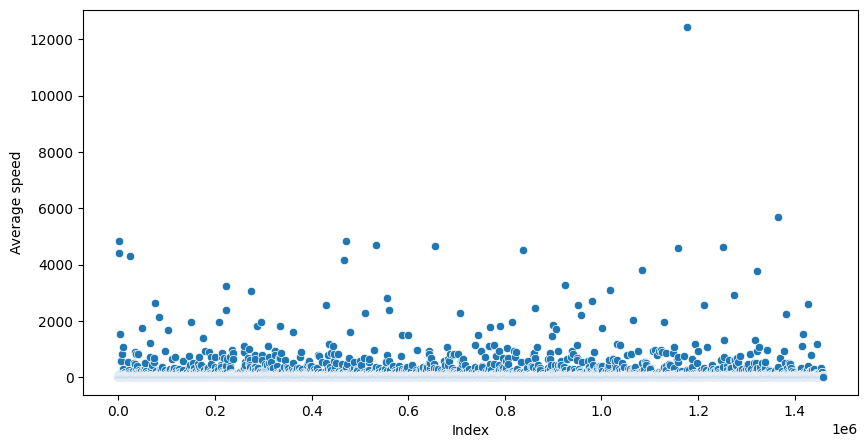

In [22]:
avg_speed = taxi_df['total_distance'] / taxi_df['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [23]:
# ваш код здесь
taxi_df = taxi_df[~(taxi_df['trip_duration'] / 3600 > 24)]

In [24]:
taxi_df = taxi_df[~(taxi_df['total_distance'] / taxi_df['trip_duration'] * 3.6 > 300)]

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [25]:
taxi_df['trip_duration_log'] = np.log1p(taxi_df['trip_duration'])

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

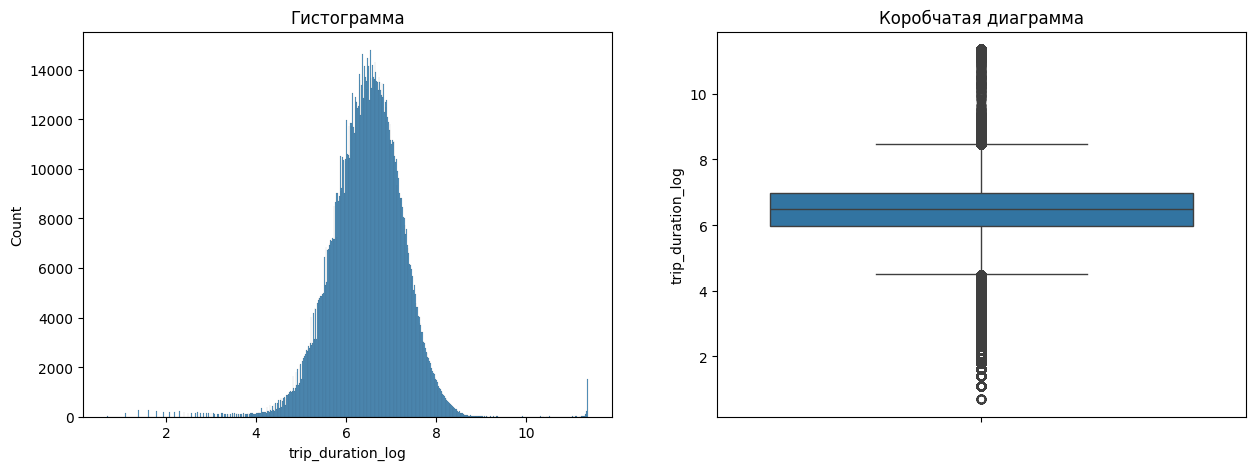

In [26]:
# ваш код здесь
fig, axes = plt.subplots(1,2, figsize=(15, 5))
sns.histplot(taxi_df['trip_duration_log'], ax=axes[0])
axes[0].set_title('Гистограмма')
sns.boxplot(taxi_df['trip_duration_log'], ax=axes[1])
axes[1].set_title('Коробчатая диаграмма');

In [27]:
def dagostino_test(data):

    # Выполняем тест Д’Агостино
    stat, p_value = stats.normaltest(data)
    
    # Уровень значимости
    alpha = 0.05
    
    # Проверяем гипотезу
    if p_value < alpha:
        result = "Отвергаем нулевую гипотезу: данные не распределены нормально."
    else:
        result = "Не отвергаем нулевую гипотезу: данные распределены нормально."
    
    return {
        'statistic': stat,
        'p_value': p_value,
        'result': result
    }

# Пример использования функции
test_result = dagostino_test(taxi_df['trip_duration_log'])
print(test_result)


{'statistic': 138350.16605405, 'p_value': 0.0, 'result': 'Отвергаем нулевую гипотезу: данные не распределены нормально.'}


### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

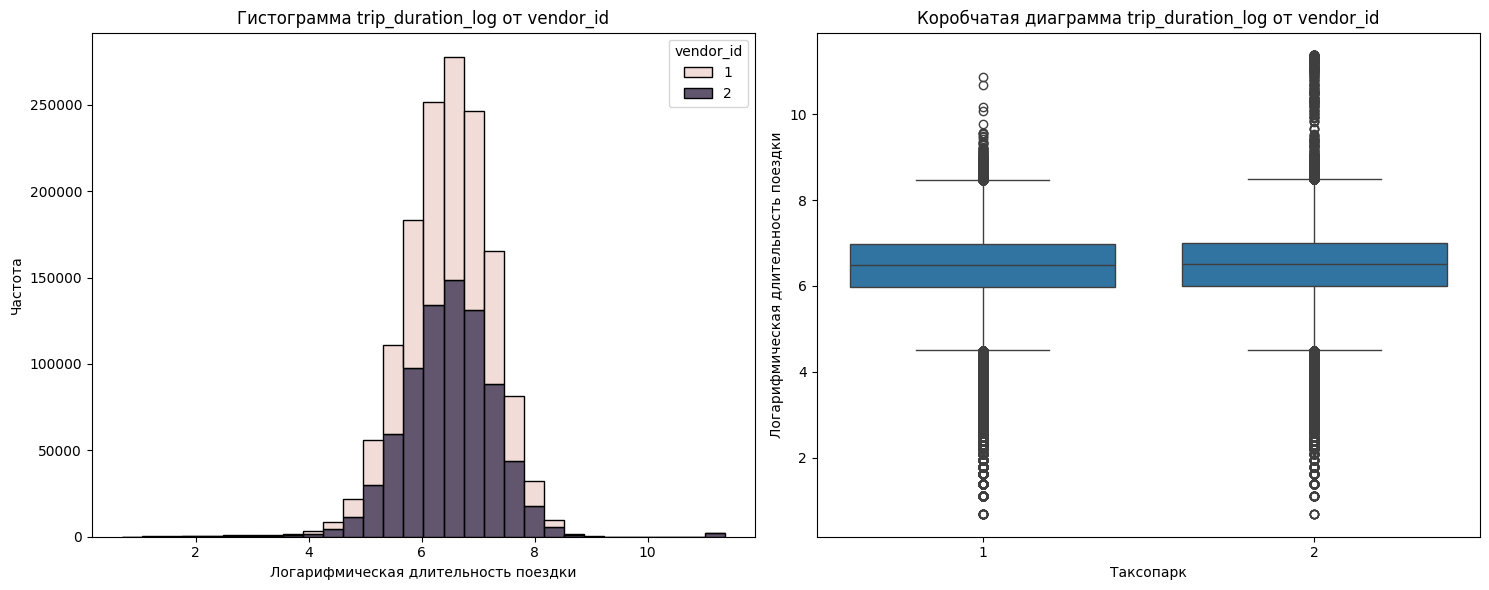

In [28]:
# Создаем фигуру и оси для графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Построение гистограммы
sns.histplot(data=taxi_df, x='trip_duration_log', hue='vendor_id', multiple='stack', ax=axes[0], bins=30)
axes[0].set_title('Гистограмма trip_duration_log от vendor_id')
axes[0].set_xlabel('Логарифмическая длительность поездки')
axes[0].set_ylabel('Частота')

# Построение коробчатой диаграммы
sns.boxplot(data=taxi_df, x='vendor_id', y='trip_duration_log', ax=axes[1])
axes[1].set_title('Коробчатая диаграмма trip_duration_log от vendor_id')
axes[1].set_xlabel('Таксопарк')
axes[1].set_ylabel('Логарифмическая длительность поездки')

# Отображение графиков
plt.tight_layout()
plt.show()

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

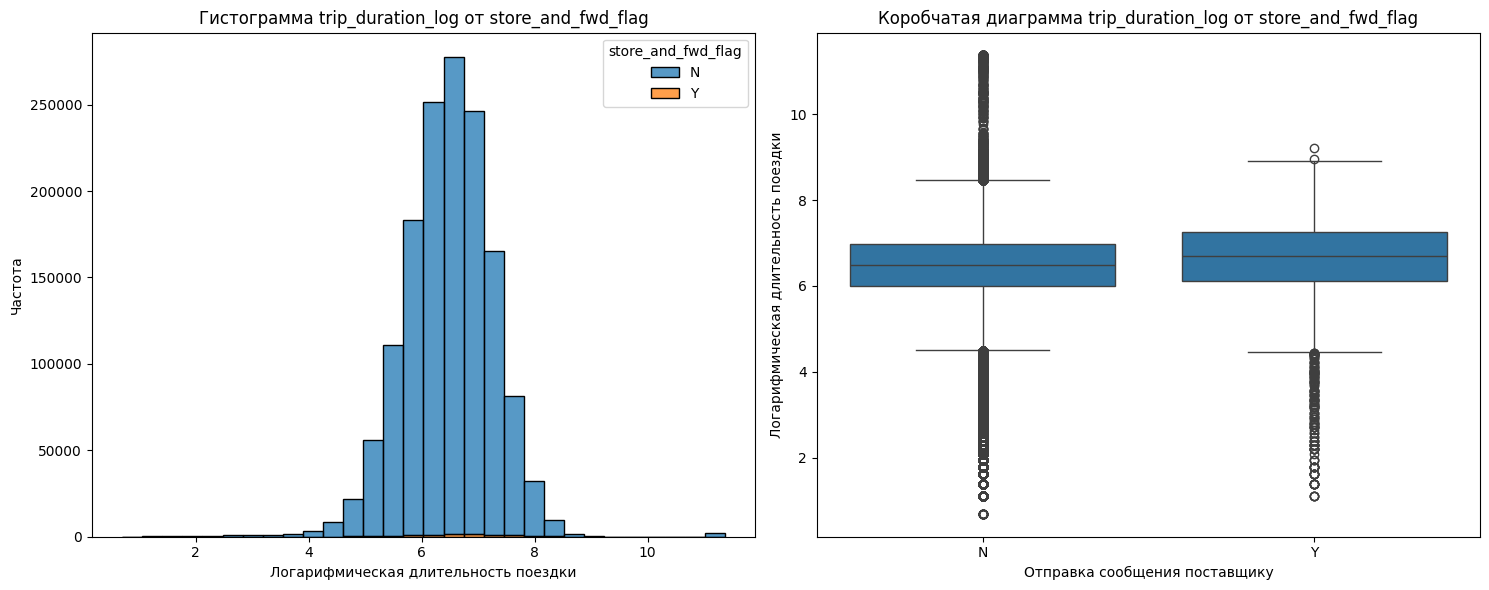

In [29]:
# Создаем фигуру и оси для графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Построение гистограммы
sns.histplot(data=taxi_df, x='trip_duration_log', hue='store_and_fwd_flag', multiple='stack', ax=axes[0], bins=30)
axes[0].set_title('Гистограмма trip_duration_log от store_and_fwd_flag')
axes[0].set_xlabel('Логарифмическая длительность поездки')
axes[0].set_ylabel('Частота')

# Построение коробчатой диаграммы
sns.boxplot(data=taxi_df, x='store_and_fwd_flag', y='trip_duration_log', ax=axes[1])
axes[1].set_title('Коробчатая диаграмма trip_duration_log от store_and_fwd_flag')
axes[1].set_xlabel('Отправка сообщения поставщику')
axes[1].set_ylabel('Логарифмическая длительность поездки')

# Отображение графиков
plt.tight_layout()
plt.show()

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

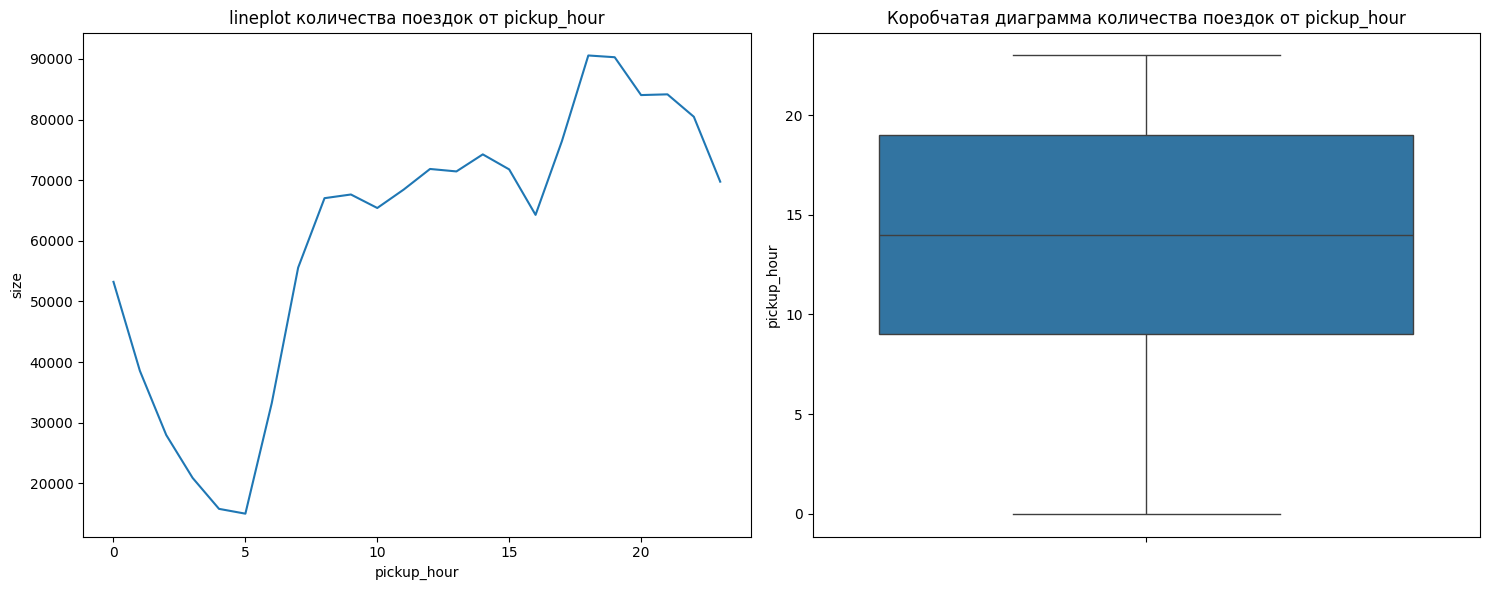

In [30]:
# Создаем фигуру и оси для графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

trip_counts = taxi_df.groupby('pickup_hour', as_index=False).size()
trip_counts
# Построение гистограммы
sns.lineplot(data=trip_counts, x='pickup_hour', y= 'size', ax=axes[0])
axes[0].set_title('lineplot количества поездок от pickup_hour')

# Построение коробчатой диаграммы
sns.boxplot(data=taxi_df['pickup_hour'], ax=axes[1])
axes[1].set_title('Коробчатая диаграмма количества поездок от pickup_hour')

# Отображение графиков
plt.tight_layout()
plt.show()

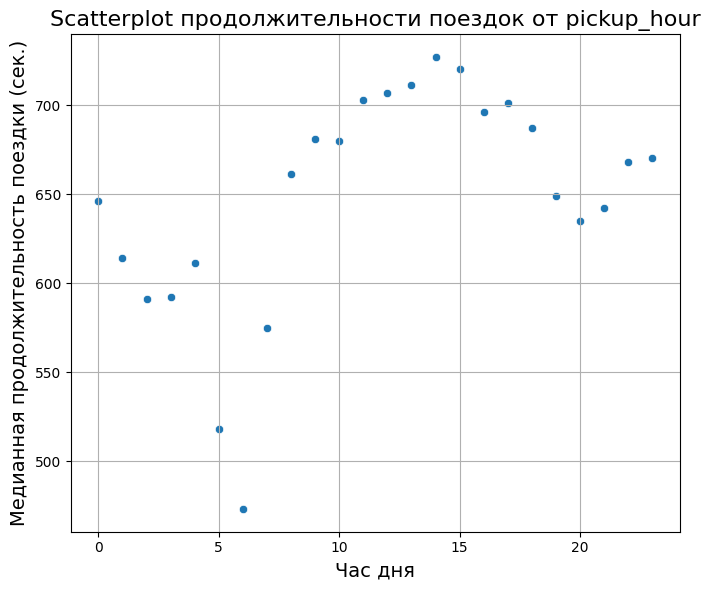

In [31]:
grouped = taxi_df.groupby('pickup_hour', as_index=False)['trip_duration'].median()
grouped
# Создаем фигуру и оси для графиков
fig, axes = plt.subplots(1, 1, figsize=(7, 6))

# Построение scatterplot
sns.scatterplot(data=grouped, x='pickup_hour', y='trip_duration', ax=axes)

# Настройка заголовка и меток
axes.set_title('Scatterplot продолжительности поездок от pickup_hour', fontsize=16)
axes.set_xlabel('Час дня', fontsize=14)
axes.set_ylabel('Медианная продолжительность поездки (сек.)', fontsize=14)

# Добавление сетки для лучшей читаемости
axes.grid(True)

# Отображение графика
plt.tight_layout()
plt.show()


### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


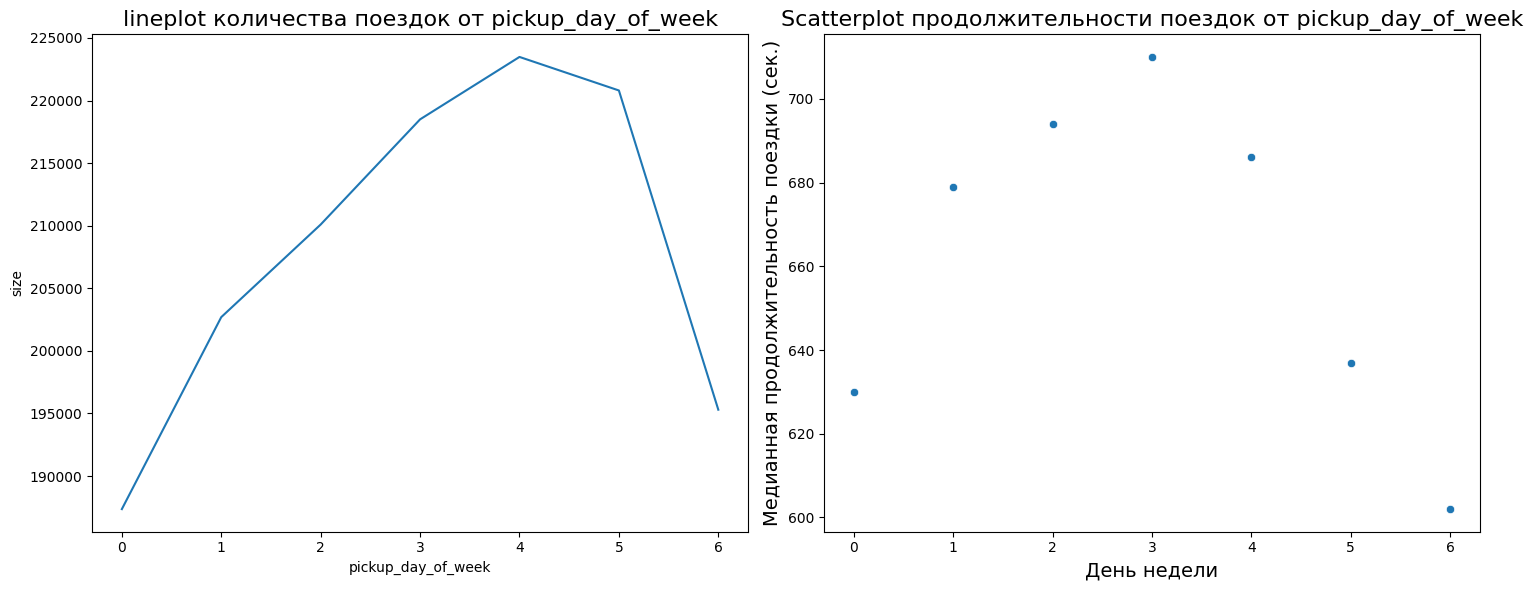

In [32]:
# Создаем фигуру и оси для графиков
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

trip_counts_week = taxi_df.groupby('pickup_day_of_week', as_index=False).size()
trip_counts_week
# Построение Диаграммы
sns.lineplot(data=trip_counts_week, x='pickup_day_of_week', y= 'size', ax=axes[0])
axes[0].set_title('lineplot количества поездок от pickup_day_of_week', fontsize=16)

grouped_week = taxi_df.groupby('pickup_day_of_week', as_index=False)['trip_duration'].median()
grouped_week

# Построение scatterplot
sns.scatterplot(data=grouped_week, x='pickup_day_of_week', y='trip_duration', ax=axes[1])

# Настройка заголовка и меток
axes[1].set_title('Scatterplot продолжительности поездок от pickup_day_of_week', fontsize=16)
axes[1].set_xlabel('День недели', fontsize=14)
axes[1].set_ylabel('Медианная продолжительность поездки (сек.)', fontsize=14)

# Отображение графика
plt.tight_layout()
plt.show()

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

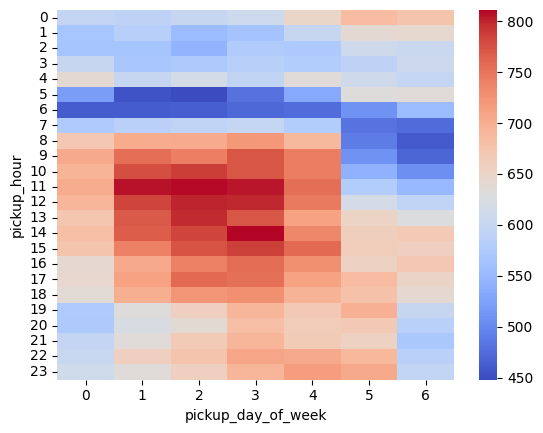

In [33]:
# ваш код здесь
pivot_data = pd.pivot_table(taxi_df, values='trip_duration', columns='pickup_day_of_week', index='pickup_hour', aggfunc='median')
pivot_data
sns.heatmap(pivot_data, cmap='coolwarm');

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [34]:
# # Задаем границы Нью-Йорка
# city_long_border = (-74.03, -73.75)
# city_lat_border = (40.63, 40.85)

# # Фильтруем данные по границам
# pickup_data = taxi_df[(taxi_df['pickup_longitude'].between(*city_long_border)) &
#                       (taxi_df['pickup_latitude'].between(*city_lat_border))]

# dropoff_data = taxi_df[(taxi_df['dropoff_longitude'].between(*city_long_border)) &
#                         (taxi_df['dropoff_latitude'].between(*city_lat_border))]

# # Создание первой диаграммы рассеяния для точек начала поездок
# fig1 = px.scatter(
#     pickup_data,
#     x='pickup_longitude',
#     y='pickup_latitude',
#     color='geo_cluster',  # Раскраска по географическим кластерам
#     title='Географическое расположение точек начала поездок',
#     labels={'pickup_longitude': 'Долгота', 'pickup_latitude': 'Широта'},
#     size_max=5  # Уменьшаем размер точек для наглядности
# )

# # Создание второй диаграммы рассеяния для точек завершения поездок
# fig2 = px.scatter(
#     dropoff_data,
#     x='dropoff_longitude',
#     y='dropoff_latitude',
#     color='geo_cluster',  # Раскраска по географическим кластерам
#     title='Географическое расположение точек завершения поездок',
#     labels={'dropoff_longitude': 'Долгота', 'dropoff_latitude': 'Широта'},
#     size_max=5  # Уменьшаем размер точек для наглядности
# )

# # Отображение графиков
# fig1.show()
# fig2.show()


## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [35]:
print('Shape of data: {}'.format(taxi_df.shape))
print('Columns: {}'.format(taxi_df.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [36]:
train_data = taxi_df.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [37]:
# ваш код здесь
train_data.drop(['id', 'dropoff_datetime'], axis=1, inplace=True)

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [38]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [39]:
# ваш код здесь
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)

In [40]:
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

In [41]:
train_data['vendor_id'].mean().__round__(2)

0.53

In [42]:
train_data['store_and_fwd_flag'].mean().__round__(3)

0.006

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установите значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Объявляем кодировщик
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [43]:
# Выбираем нужные столбцы для кодирования
columns_to_encode = ['pickup_day_of_week', 'geo_cluster', 'events']

# Объявляем кодировщик
one_hot_encoder = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore')

# Применяем кодировщик к выбранным столбцам
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_encode])

# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out(columns_to_encode)

# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot.toarray(), columns=column_names)
data_onehot.head()



,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Добавим полученную таблицу с закодированными признаками:

In [44]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_encode, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


In [45]:
# creating list of numeric features
features_for_z = train_data.nunique()[train_data.nunique() > 20]
features_for_z.index

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'pickup_hour', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance',
       'direction', 'temperature', 'wind speed', 'precip',
       'trip_duration_log'],
      dtype='object')

In [46]:
# #Visualisation for numeric features
# n = len(features_for_z.index) #number of features
# fig, axes = plt.subplots(n, 2, figsize=(15, 60)) #figure+n*2 coordinate planes
# for i, feature in enumerate(features_for_z.index):
#     #build a pie for the percentage of each of the feature
#     hisplot = sns.histplot(train_data, x=feature, ax=axes[i][0]);
#     hisplot.set_title('Гистограмма {}'.format(feature))
#     #build bar charts to demonstrate the dependence of each feature on the target
#     boxplot = sns.boxplot(train_data, x=feature, ax=axes[i][1]);
#     boxplot.set_title('Коробчатая диаграмма {}'.format(feature))
# plt.tight_layout() #alignment of graphs

In [47]:
# Z range test
def outliers_z_score(data, feature_lst, log_scale=False):
    for feature in feature_lst:
        print(feature)
        if log_scale:
            x = np.log(data[feature]+1)
        else:
            x = data[feature]
        mu = x.mean()
        sigma = x.std()
        lower_bound = mu - 3 * sigma
        print('lower bound: {}'.format(round(lower_bound)))
        upper_bound = mu + 3 * sigma
        print('upper_bound: {}'.format(round(upper_bound)))
        outliers = data[(x < lower_bound) | (x > upper_bound)]
        cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
        print('Number of outliers after z-deviation method in {}: {}'.format(feature, outliers.shape[0]))
        print('The resulting number of records in {}: {}'.format(feature, cleaned.shape[0]))
        print('')
        data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]

    return data

train_data_cleaned = outliers_z_score(train_data, features_for_z.index, log_scale=False)

pickup_longitude
lower bound: -74
upper_bound: -74
Number of outliers after z-deviation method in pickup_longitude: 365
The resulting number of records in pickup_longitude: 1457868

pickup_latitude
lower bound: 41
upper_bound: 41
Number of outliers after z-deviation method in pickup_latitude: 36048
The resulting number of records in pickup_latitude: 1421820

dropoff_longitude
lower bound: -74
upper_bound: -74
Number of outliers after z-deviation method in dropoff_longitude: 32053
The resulting number of records in dropoff_longitude: 1389767

dropoff_latitude
lower bound: 41
upper_bound: 41
Number of outliers after z-deviation method in dropoff_latitude: 20006
The resulting number of records in dropoff_latitude: 1369761

trip_duration
lower bound: -8473
upper_bound: 10215
Number of outliers after z-deviation method in trip_duration: 1894
The resulting number of records in trip_duration: 1367867

pickup_hour
lower bound: -5
upper_bound: 33
Number of outliers after z-deviation method in p

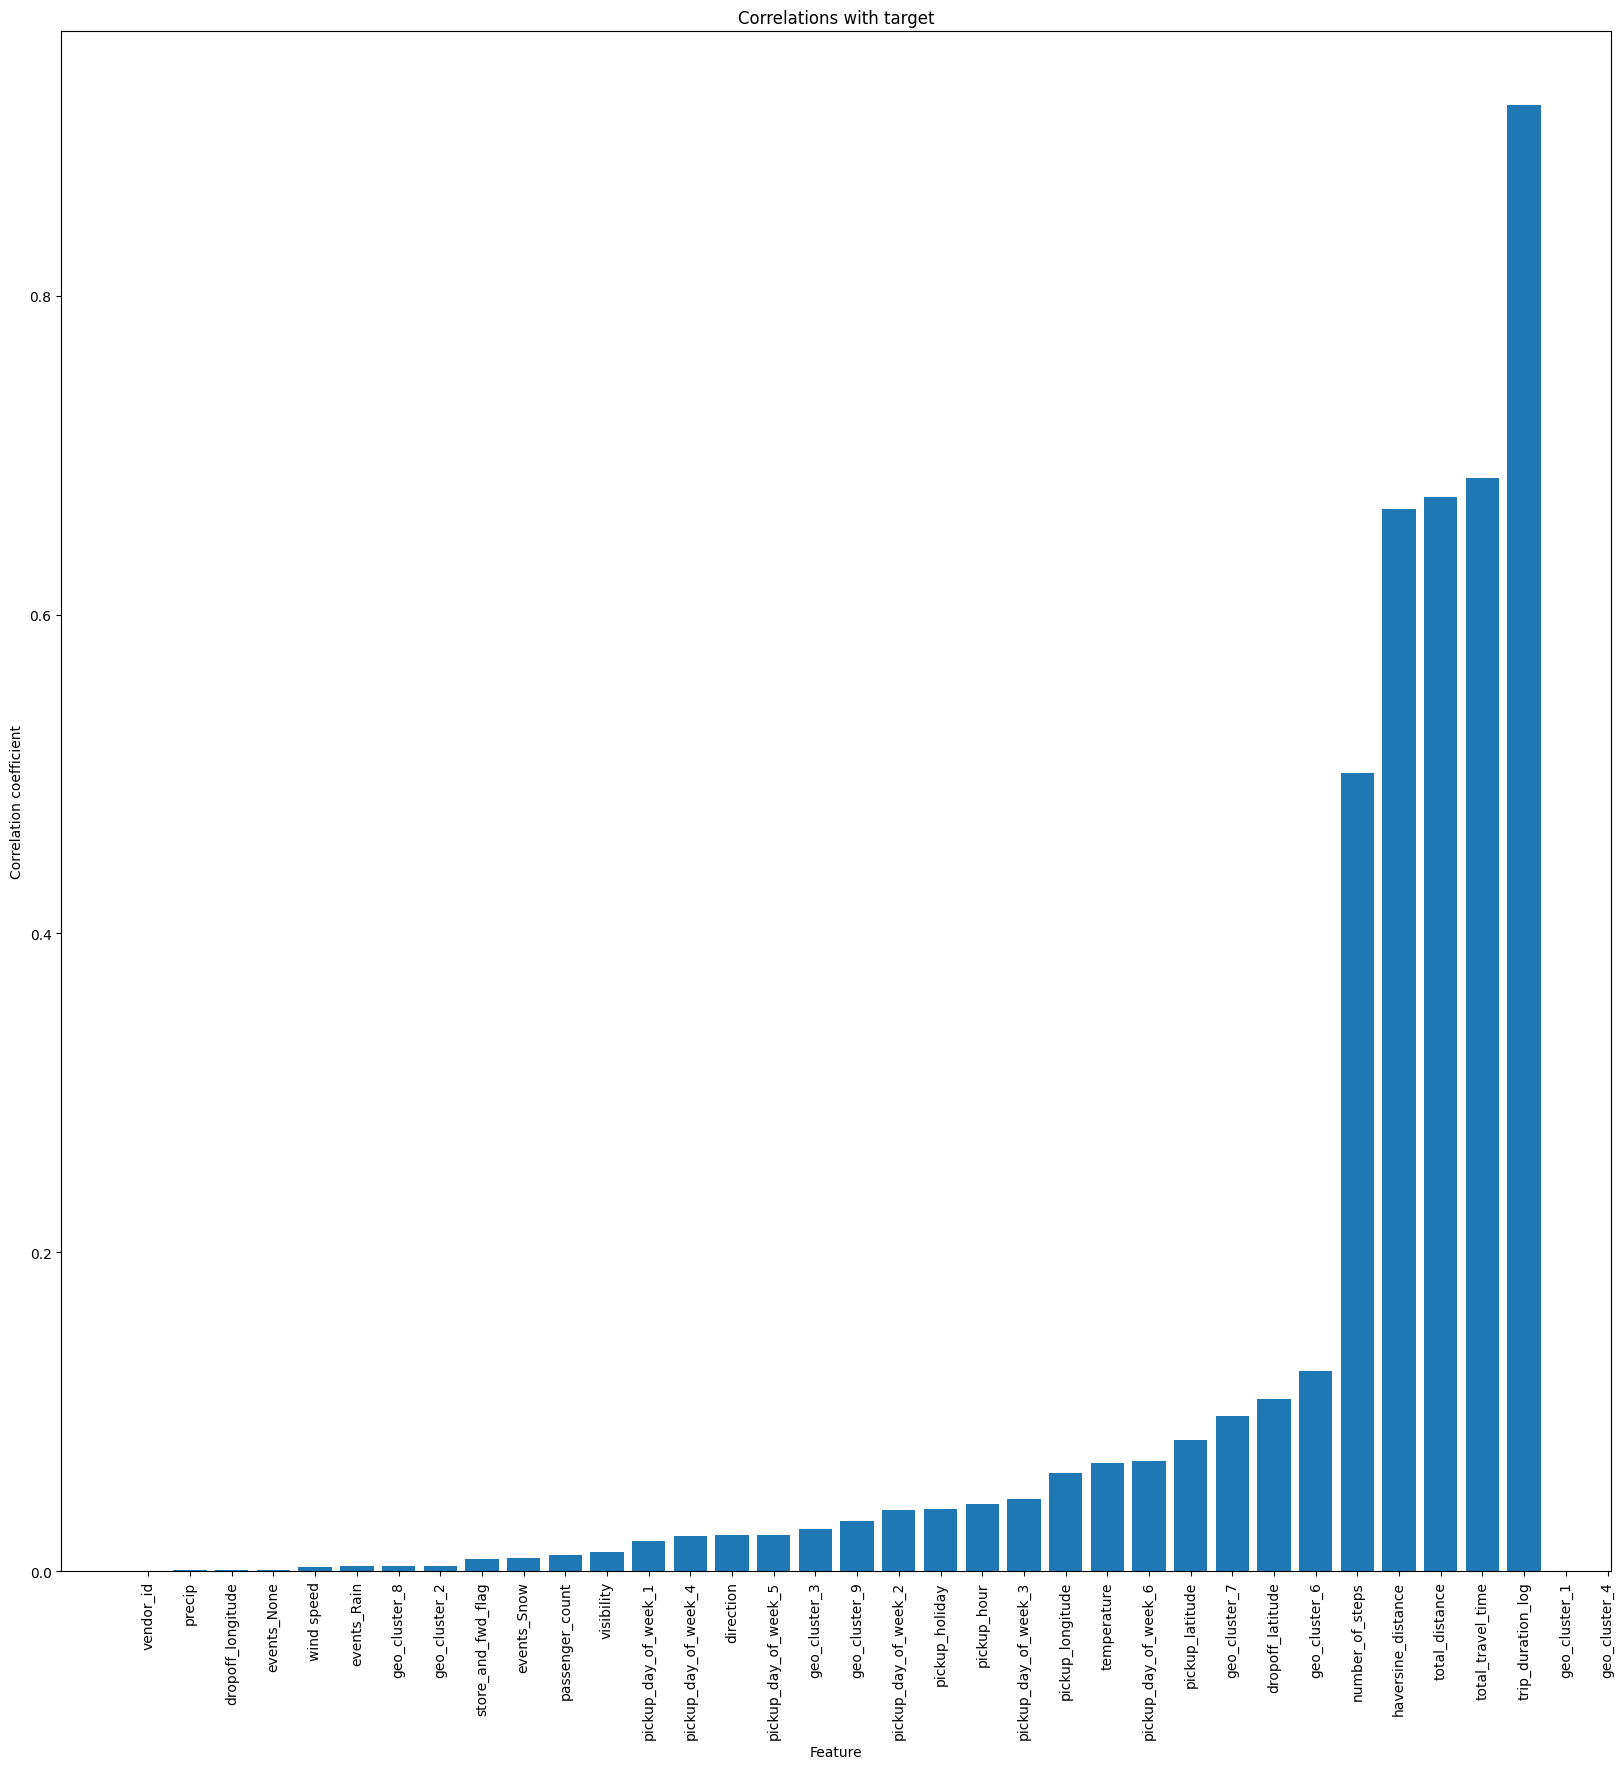

In [48]:
#Calculating the correlation module
corr_with_target = train_data_cleaned.corr()['trip_duration'].abs().sort_values()
#Removing the correlation of the target variable with itself
corr_with_target = corr_with_target.drop('trip_duration')
#Building a bar chart of correlations
fig, ax = plt.subplots(figsize=(20, 20))
ax.bar(corr_with_target.index, corr_with_target.values)
ax.set_title('Correlations with target') 
ax.set_xlabel('Feature')
ax.set_ylabel('Сorrelation coefficient');
ax.xaxis.set_tick_params(rotation=90)

### Calculating correlation pairs

In [49]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

corr_pairs = get_top_abs_correlations(train_data_cleaned, 20)
corr_pairs

total_distance      haversine_distance    0.958420
trip_duration       trip_duration_log     0.919728
total_distance      total_travel_time     0.916688
total_travel_time   haversine_distance    0.911513
events_None         events_Rain           0.889671
total_distance      number_of_steps       0.723257
total_travel_time   number_of_steps       0.702529
                    trip_duration_log     0.700425
dropoff_latitude    geo_cluster_9         0.688685
trip_duration       total_travel_time     0.685935
                    total_distance        0.673413
total_distance      trip_duration_log     0.671020
haversine_distance  trip_duration_log     0.669426
trip_duration       haversine_distance    0.666402
dropoff_latitude    geo_cluster_6         0.653881
pickup_latitude     geo_cluster_6         0.638345
number_of_steps     haversine_distance    0.631871
pickup_latitude     dropoff_latitude      0.617985
pickup_longitude    pickup_latitude       0.612843
precip              events_None

In [77]:
train_data_cleaned = train_data_cleaned.drop(['haversine_distance', 'trip_duration', 'total_travel_time'], axis=1)

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [78]:
X = train_data_cleaned.drop('trip_duration_log', axis=1)
# y = train_data['trip_duration']
y_log = train_data_cleaned['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [79]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [53]:
# # ваш код здесь
# selector = feature_selection.SelectKBest(feature_selection.f_regression, k=25)
# selector.fit(X_train, y_train_log)
 
# feature_lst = selector.get_feature_names_out()
# X_train = X_train[feature_lst]
# X_valid = X_valid[feature_lst]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [80]:
# ваш код здесь
scaler = preprocessing.MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [81]:
np.round(X_valid_scaled[:,0].mean(), 2)

0.53

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [82]:
# ваш код здесь
model = linear_model.LinearRegression()
model.fit(X_train_scaled, y_train_log)
y_pred_log = model.predict(X_valid_scaled)

# Вычисляем RMSLE
# Для этого сначала находим MSE между истинными и предсказанными значениями в логарифмическом масштабе
mse = metrics.mean_squared_error(y_valid_log, y_pred_log)
rmsle_valid = np.sqrt(mse)

# Для тренировочной выборки также вычисляем RMSLE
y_pred_train_log = model.predict(X_train_scaled)
mse_train = metrics.mean_squared_error(y_train_log, y_pred_train_log)
rmsle_train = np.sqrt(mse_train)

# Округляем результаты до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {rmsle_train_rounded}')
print(f'RMSLE на валидационной выборке: {rmsle_valid_rounded}')

RMSLE на тренировочной выборке: 0.46
RMSLE на валидационной выборке: 0.46


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [83]:
# Генерируем полиномиальные признаки 2-ой степени
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly.transform(X_valid_scaled)

# Обучаем модель полиномиальной регрессии
model_poly = linear_model.LinearRegression()
model_poly.fit(X_train_scaled_poly, y_train_log)

# Делаем предсказания на валидационной выборке
y_pred_log_valid = model_poly.predict(X_valid_scaled_poly)
y_pred_log_train = model_poly.predict(X_train_scaled_poly)

# Вычисляем RMSLE
mse_valid = metrics.mean_squared_error(y_valid_log, y_pred_log_valid)
rmsle_valid = np.sqrt(mse_valid)

mse_train = metrics.mean_squared_error(y_train_log, y_pred_log_train)
rmsle_train = np.sqrt(mse_train)

# Округляем результаты до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {rmsle_train_rounded}')
print(f'RMSLE на валидационной выборке: {rmsle_valid_rounded}')

RMSLE на тренировочной выборке: 0.39
RMSLE на валидационной выборке: 3010584.99


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [84]:
# ваш код здесь
# Генерируем полиномиальные признаки 2-ой степени
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly.transform(X_valid_scaled)

# Обучаем модель полиномиальной регрессии с L2-регуляризацией (Ridge)
alpha = 1
model_ridge = linear_model.Ridge(alpha=alpha)
model_ridge.fit(X_train_scaled_poly, y_train_log)

# Делаем предсказания на валидационной выборке
y_pred_log_valid = model_ridge.predict(X_valid_scaled_poly)
y_pred_log_train = model_ridge.predict(X_train_scaled_poly)

# Вычисляем RMSLE
mse_valid = metrics.mean_squared_error(y_valid_log, y_pred_log_valid)
rmsle_valid = np.sqrt(mse_valid)

mse_train = metrics.mean_squared_error(y_train_log, y_pred_log_train)
rmsle_train = np.sqrt(mse_train)

# Округляем результаты до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {rmsle_train_rounded}')
print(f'RMSLE на валидационной выборке: {rmsle_valid_rounded}')

RMSLE на тренировочной выборке: 0.39
RMSLE на валидационной выборке: 0.39


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [85]:
model = tree.DecisionTreeRegressor(random_state=42)
model.fit(X_train_scaled, y_train_log)
y_pred_log = model.predict(X_valid_scaled)

# Вычисляем RMSLE
# Для этого сначала находим MSE между истинными и предсказанными значениями в логарифмическом масштабе
mse = metrics.mean_squared_error(y_valid_log, y_pred_log)
rmsle_valid = np.sqrt(mse)

# Для тренировочной выборки также вычисляем RMSLE
y_pred_train_log = model.predict(X_train_scaled)
mse_train = metrics.mean_squared_error(y_train_log, y_pred_train_log)
rmsle_train = np.sqrt(mse_train)

# Округляем результаты до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {rmsle_train_rounded}')
print(f'RMSLE на валидационной выборке: {rmsle_valid_rounded}')

RMSLE на тренировочной выборке: 0.0
RMSLE на валидационной выборке: 0.46


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


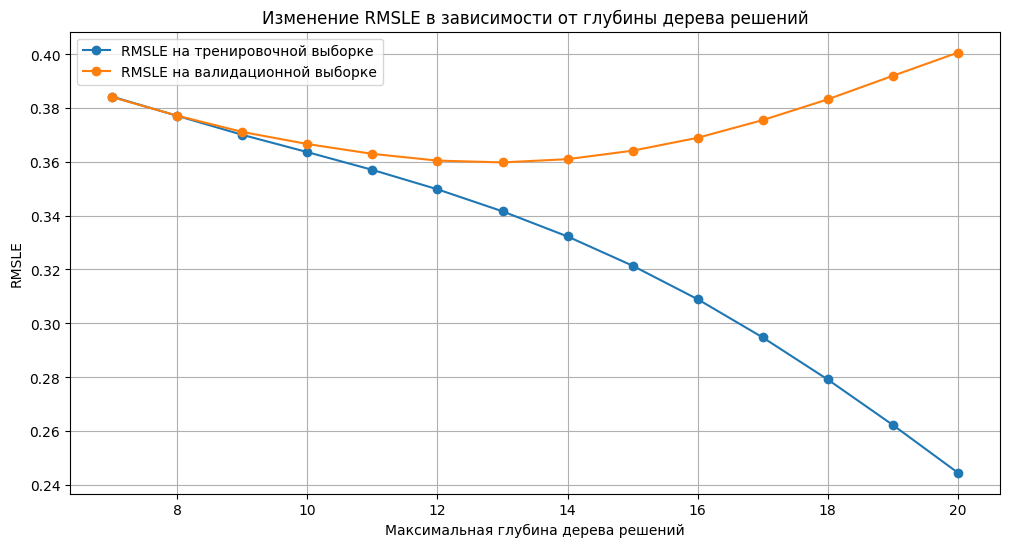

Оптимальная глубина дерева: 13
RMSLE на тренировочной выборке: 0.34
RMSLE на валидационной выборке: 0.36


In [86]:
# Параметры
max_depths = range(7, 21)
random_state = 42

# Списки для хранения значений RMSLE
rmsle_train = []
rmsle_valid = []

# Перебор всех возможных значений глубины дерева
for max_depth in max_depths:
    model = tree.DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
    model.fit(X_train_scaled, y_train_log)
    
    # Предсказания
    y_pred_train_log = model.predict(X_train_scaled)
    y_pred_valid_log = model.predict(X_valid_scaled)

    # Вычисление RMSLE
    mse_train = metrics.mean_squared_error(y_train_log, y_pred_train_log)
    rmsle_train.append(np.sqrt(mse_train))
    
    mse_valid = metrics.mean_squared_error(y_valid_log, y_pred_valid_log)
    rmsle_valid.append(np.sqrt(mse_valid))

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(max_depths, rmsle_train, label='RMSLE на тренировочной выборке', marker='o')
plt.plot(max_depths, rmsle_valid, label='RMSLE на валидационной выборке', marker='o')
plt.title('Изменение RMSLE в зависимости от глубины дерева решений')
plt.xlabel('Максимальная глубина дерева решений')
plt.ylabel('RMSLE')
plt.legend()
plt.grid()
plt.show()

# Поиск оптимальной глубины
optimal_depth = max_depths[np.argmin(rmsle_valid)]
optimal_rmsle_train = round(rmsle_train[np.argmin(rmsle_valid)], 2)
optimal_rmsle_valid = round(rmsle_valid[np.argmin(rmsle_valid)], 2)

print(f'Оптимальная глубина дерева: {optimal_depth}')
print(f'RMSLE на тренировочной выборке: {optimal_rmsle_train}')
print(f'RMSLE на валидационной выборке: {optimal_rmsle_valid}')


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [87]:
# ваш код здесь
model_rf = ensemble.RandomForestRegressor(n_estimators=200, max_depth=12, criterion='squared_error', min_samples_split=20,
                                       random_state=42)
model_rf.fit(X_train_scaled, y_train_log)
y_pred_log = model.predict(X_valid_scaled)

# Вычисляем RMSLE
# Для этого сначала находим MSE между истинными и предсказанными значениями в логарифмическом масштабе
mse = metrics.mean_squared_error(y_valid_log, y_pred_log)
rmsle_valid = np.sqrt(mse)

# Для тренировочной выборки также вычисляем RMSLE
y_pred_train_log = model_rf.predict(X_train_scaled)
mse_train = metrics.mean_squared_error(y_train_log, y_pred_train_log)
rmsle_train = np.sqrt(mse_train)

# Округляем результаты до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {rmsle_train_rounded}')
print(f'RMSLE на валидационной выборке: {rmsle_valid_rounded}')

RMSLE на тренировочной выборке: 0.34
RMSLE на валидационной выборке: 0.4


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [88]:
# ваш код здесь
model_gb = ensemble.GradientBoostingRegressor(learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=30,
                                           random_state=42)
model_gb.fit(X_train_scaled, y_train_log)
y_pred_log = model_gb.predict(X_valid_scaled)

# Вычисляем RMSLE
# Для этого сначала находим MSE между истинными и предсказанными значениями в логарифмическом масштабе
mse = metrics.mean_squared_error(y_valid_log, y_pred_log)
rmsle_valid = np.sqrt(mse)

# Для тренировочной выборки также вычисляем RMSLE
y_pred_train_log = model_gb.predict(X_train_scaled)
mse_train = metrics.mean_squared_error(y_train_log, y_pred_train_log)
rmsle_train = np.sqrt(mse_train)

# Округляем результаты до сотых
rmsle_train_rounded = round(rmsle_train, 2)
rmsle_valid_rounded = round(rmsle_valid, 2)

# Выводим результаты
print(f'RMSLE на тренировочной выборке: {rmsle_train_rounded}')
print(f'RMSLE на валидационной выборке: {rmsle_valid_rounded}')

RMSLE на тренировочной выборке: 0.31
RMSLE на валидационной выборке: 0.32


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


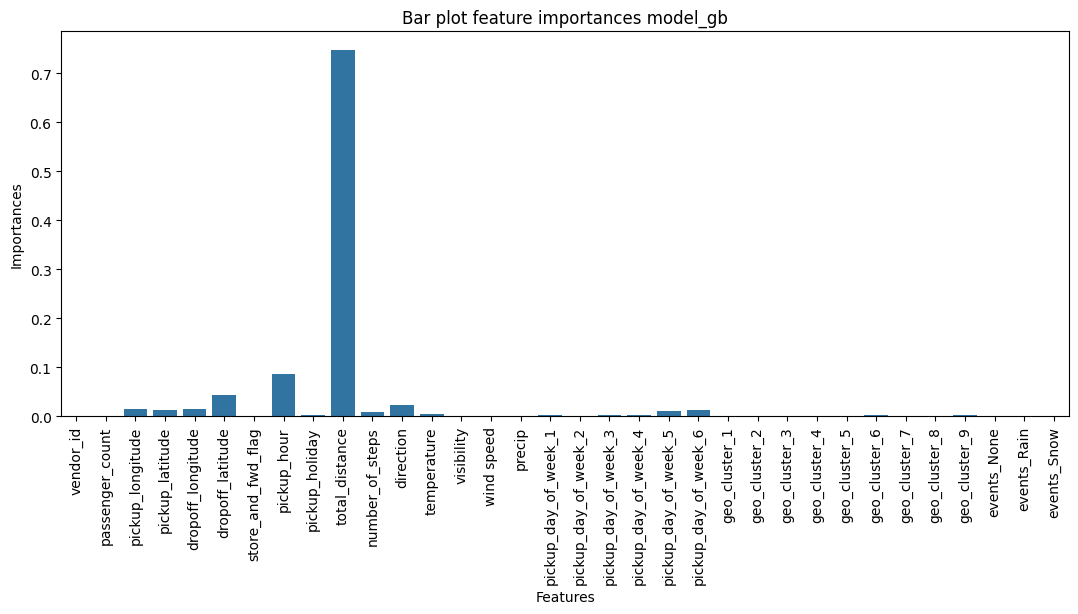

In [89]:
# ваш код здесь
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns 
feature_importances = model_gb.feature_importances_

sns.barplot(x=feature, y=feature_importances, ax=ax);
ax.set_title('Bar plot feature importances model_gb')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
plt.xticks(rotation = 90);

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [90]:
y_pred_gb = np.expm1(y_pred_log)
y_valid = np.expm1(y_valid_log)
mae_valid_min = round(metrics.median_absolute_error(y_valid, y_pred_gb) / 60, 1)

# Выводим результаты
print(f'MAE на валидационной выборке: {mae_valid_min}')

MAE на валидационной выборке: 1.6


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [108]:
test_data = pd.read_csv("Project5_test_data.csv")
osrm_data_test = pd.read_csv("Project5_osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [109]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data['geo_cluster'].value_counts()
test_data = add_weather_features(test_data, weather_data)
display(test_data['events'].value_counts())
test_data = fill_null_weather_data(test_data, weather_col)
display(test_data['events'].value_counts())

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_encode])
column_names = one_hot_encoder.get_feature_names_out(columns_to_encode)
display(column_names)
test_data_onehot = pd.DataFrame(test_data_onehot.toarray(), columns=column_names)
display(data_onehot.head())
display(test_data_onehot.head())

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_encode, axis=1), test_data_onehot], 
    axis=1
)
missing_columns = [col for col in scaler.feature_names_in_ if col not in test_data.columns]
print("Missing columns in test_data:", missing_columns)

test_data = test_data.drop(['haversine_distance', 'total_travel_time'], axis=1)
X_test_scaled = scaler.transform(test_data)
print('Shape of data: {}'.format(X_test_scaled.shape))

None    589229
Rain     25071
Snow      5689
Fog          1
Name: events, dtype: int64

None    589229
Rain     25071
Snow      5689
Fog          1
Name: events, dtype: int64

array(['pickup_day_of_week_1', 'pickup_day_of_week_2',
       'pickup_day_of_week_3', 'pickup_day_of_week_4',
       'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_1',
       'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_4', 'geo_cluster_6',
       'geo_cluster_7', 'geo_cluster_8', 'geo_cluster_9', 'events_None',
       'events_Rain', 'events_Snow', 'events_nan'], dtype=object)

,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow,events_nan
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Missing columns in test_data: ['geo_cluster_5']


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- events_nan
- id
- pickup_date
- pickup_datetime
Feature names seen at fit time, yet now missing:
- geo_cluster_5


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [161]:
pred_gb = model.predict(X_test_scaled)
pred_gb = np.expm1(pred_gb)

In [162]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': pred_gb})
submission.to_csv('submis_gb_vs_z_all.csv', index=False)

In [163]:
submission

,id,trip_duration
0,id3004672,832.081025
1,id3505355,404.000000
2,id1217141,358.136380
3,id2150126,803.405118
4,id1598245,300.591549
...,...,...
625129,id3008929,309.793001
625130,id3700764,986.852438
625131,id2568735,1474.000000
625132,id1384355,4002.000000


### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

После чего модуль можно импортировать:

In [164]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [ ]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log)
dtest = xgb.DMatrix(X_test_scaled)

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [169]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model_xgb = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.74021	valid-rmse:0.74223
[10]	train-rmse:0.49112	valid-rmse:0.49377
[20]	train-rmse:0.44033	valid-rmse:0.44319
[30]	train-rmse:0.42608	valid-rmse:0.42914
[40]	train-rmse:0.41870	valid-rmse:0.42206
[50]	train-rmse:0.41347	valid-rmse:0.41703
[60]	train-rmse:0.40952	valid-rmse:0.41342
[70]	train-rmse:0.40605	valid-rmse:0.41022
[80]	train-rmse:0.40351	valid-rmse:0.40799
[90]	train-rmse:0.40161	valid-rmse:0.40636
[100]	train-rmse:0.39994	valid-rmse:0.40494
[110]	train-rmse:0.39834	valid-rmse:0.40366
[120]	train-rmse:0.39698	valid-rmse:0.40266
[130]	train-rmse:0.39582	valid-rmse:0.40176
[140]	train-rmse:0.39470	valid-rmse:0.40092
[150]	train-rmse:0.39375	valid-rmse:0.40027
[160]	train-rmse:0.39282	valid-rmse:0.39975
[170]	train-rmse:0.39181	valid-rmse:0.39908
[180]	train-rmse:0.39104	valid-rmse:0.39853
[190]	train-rmse:0.39033	valid-rmse:0.39803
[200]	train-rmse:0.38958	valid-rmse:0.39759
[210]	train-rmse:0.38889	valid-rmse:0.39714
[220]	train-rmse:0.38820	valid-rmse:0.39685

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [170]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.expm1(model_xgb.predict(dtest))
print('Modeling RMSLE %.5f' % model_xgb.best_score)

Modeling RMSLE 0.39453


In [172]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('submis_xgb_vs_z_all.csv', index=False)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

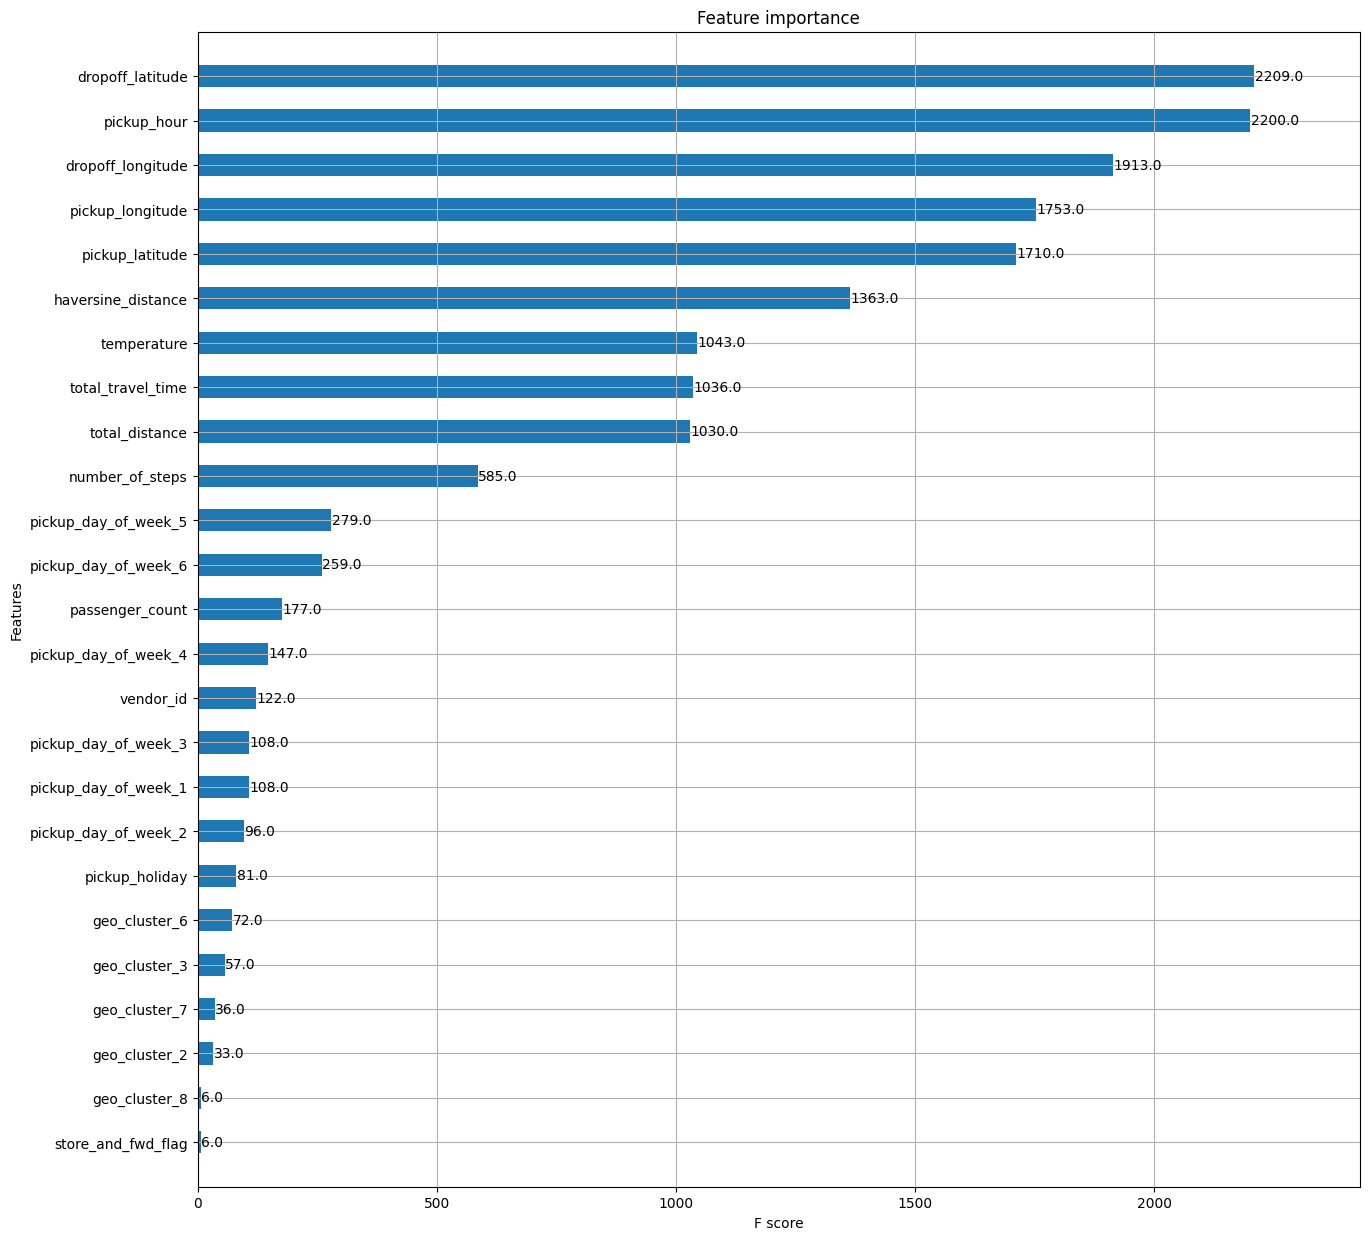

In [171]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model_xgb, ax = ax, height=0.5)

In [ ]:
# # ваш код здесь
# model_gb = ensemble.GradientBoostingRegressor(learning_rate=0.5, n_estimators=100, max_depth=6, min_samples_split=30,
#                                            random_state=42)
# model_gb.fit(X_train_scaled, y_train_log)
# y_pred_log = model_gb.predict(X_valid_scaled)

# # Вычисляем RMSLE
# # Для этого сначала находим MSE между истинными и предсказанными значениями в логарифмическом масштабе
# mse = metrics.mean_squared_error(y_valid_log, y_pred_log)
# rmsle_valid = np.sqrt(mse)

# # Для тренировочной выборки также вычисляем RMSLE
# y_pred_train_log = model_gb.predict(X_train_scaled)
# mse_train = metrics.mean_squared_error(y_train_log, y_pred_train_log)
# rmsle_train = np.sqrt(mse_train)

# # Округляем результаты до сотых
# rmsle_train_rounded = round(rmsle_train, 2)
# rmsle_valid_rounded = round(rmsle_valid, 2)

# # Выводим результаты
# print(f'RMSLE на тренировочной выборке: {rmsle_train_rounded}')
# print(f'RMSLE на валидационной выборке: {rmsle_valid_rounded}')

In [181]:
# def optuna_gb_hyper(trial):
#     # задаем пространства поиска гиперпараметров
#     n_estimators = trial.suggest_int('n_estimators', 100, 500, 10)
#     max_depth = trial.suggest_int('max_depth', 3, 10, 1)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20, 1)
    
#     feat = ['sqrt', 'log2', None]
#     max_features = trial.suggest_categorical('max_features', feat)
    
#     crit = ['friedman_mse', 'squared_error']
#     criterion = trial.suggest_categorical('criterion', crit)
    
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, step=0.01)
#     alpha = trial.suggest_float('alpha', 0.0, 1.0, step=0.1)

#     # создаем модель
#     model_gb_hyper = ensemble.GradientBoostingRegressor(n_estimators=n_estimators,
#                                         max_depth=max_depth,
#                                         min_samples_leaf=min_samples_leaf,
#                                         min_samples_split=min_samples_split,
#                                         max_features=max_features,
#                                         criterion=criterion,
#                                         learning_rate=learning_rate,
#                                         alpha=alpha,
#                                         random_state=42)

#     # применим кросс-валидацию
#     score_gb_hyper = cross_val_score(model_gb_hyper, X_train_scaled, y_train_log, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()

#     return -score_gb_hyper


In [182]:
# %%time
# # cоздаем объект исследования
# # можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
# study_gb_hyper = optuna.create_study(study_name="GradientBoostingRegressor")
# # ищем лучшую комбинацию гиперпараметров n_trials раз
# study_gb_hyper.optimize(optuna_gb_hyper, n_trials=100)

[I 2024-12-17 22:06:48,066] A new study created in memory with name: GradientBoostingRegressor
C:\Users\ceasa\AppData\Local\Temp\ipykernel_13012\15646854.py:3: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

C:\Users\ceasa\AppData\Local\Temp\ipykernel_13012\15646854.py:4: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

C:\Users\ceasa\AppData\Local\Temp\ipykernel_13012\15646854.py:5: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

C:\Users\ceasa\AppData\Local\Temp\ipykernel_13012\15646854.py:6: FutureWarning:

suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.

[I 2024-12-17 23:54:42,254] Trial 0 finished with value: 0.1489458541702173 and parameters: {'n_estimators': 230, 'max_depth': 7, 'min_samples_le

KeyboardInterrupt: 

In [ ]:
# # выводим результаты на обучающей выборке
# print("Наилучшие значения гиперпараметров {}".format(study_gb_hyper.best_params))
# print("MSE на обучающем наборе: {:.2f}".format(study_gb_hyper.best_value))